# CPE 595 Homework 4 - Sigmoid Function

## Question 1: Programming

### Step 1:  Data Acquisition and Visualization

In [4]:
import numpy as np
import struct
import gzip
import matplotlib.pyplot as plt

# reading IDX files
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [15]:
# Load the MNIST Dataset
# Define the file paths for the downloaded dataset
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'
test_images_path = 't10k-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'

# Load the datasets using the read_idx function
train_images = read_idx(train_images_path)
train_labels = read_idx(train_labels_path)
test_images = read_idx(test_images_path)
test_labels = read_idx(test_labels_path)

# Print out the shapes of each dataset array
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


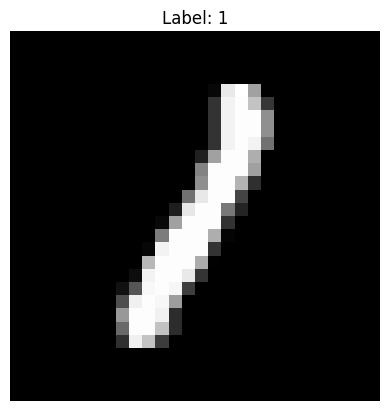

In [17]:
# Plot some sample images from the dataset

import random

# Choose a random index from the training data
random_index = random.randint(0, train_images.shape[0] - 1)

# Display the image using plt.imshow with a grayscale colormap
plt.imshow(train_images[random_index], cmap='gray')
plt.title("Label: {}".format(train_labels[random_index]))
plt.axis('off')  # Hide the axis for better visualization
plt.show()
